In [137]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [151]:
annot_raw = pd.read_csv(
    'data/viral_spectra_dataset.csv', 
    usecols=['Type','taxname','df','taxid','virusname']
)
annot = annot_raw.query('df == "nemu"').copy()

annot['taxid'] = annot['taxid'].astype(int)
annot.set_index('taxid', inplace=True)
del annot['df']
annot.head()

,Type,taxname,virusname
taxid,,,
10407,ds,Hepatitis B virus,HBV
10990,ds,Rice black streaked dwarf virus,RBSDV
11082,+,West Nile virus,WNV
11983,+,Norwalk virus,norw
12092,+,Hepatovirus A,HAV


In [139]:
obs_aa_freqs = pd.read_csv('./data/aminoacid_freq_all_virus.csv', index_col=0)
    # .join(annot).dropna() # TODO remove dropna whan we update the dataset of amino acid frequencies???
del obs_aa_freqs['refseq_id']
del obs_aa_freqs['X']
print(obs_aa_freqs.shape)
aa_order = obs_aa_freqs.columns[:20]
obs_aa_freqs_long = obs_aa_freqs.melt(
    var_name='amino_acid', 
    value_name='obs_freq',
    ignore_index=False,
).reset_index()
obs_aa_freqs_long

(32, 20)


,taxid,amino_acid,obs_freq
0,10407,M,0.019324
1,10990,M,0.024014
2,11082,M,0.032028
3,1133363,M,0.031650
4,1157337,M,0.029342
...,...,...,...
635,54290,N,0.017751
636,57482,N,0.041644
637,693997,N,0.060734
638,694014,N,0.052541


In [ ]:
eq_aa_freqs = pd.read_csv('./data/aminoacid_eq_freq_all_virus.csv', index_col=0)[aa_order]
eq_aa_freqs_long = eq_aa_freqs.melt(
    var_name='amino_acid', 
    value_name='eq_freq',
    ignore_index=False,
).reset_index()
eq_aa_freqs_long

,taxid,amino_acid,eq_freq
0,10407,M,0.012721
1,10990,M,0.010919
2,11082,M,0.021009
3,11320,M,0.020867
4,11983,M,0.014603
...,...,...,...
635,1678143,N,0.012894
636,1933178,N,0.073512
637,3052230,N,0.014120
638,3052493,N,0.065858


<Axes: xlabel='obs_freq', ylabel='eq_freq'>

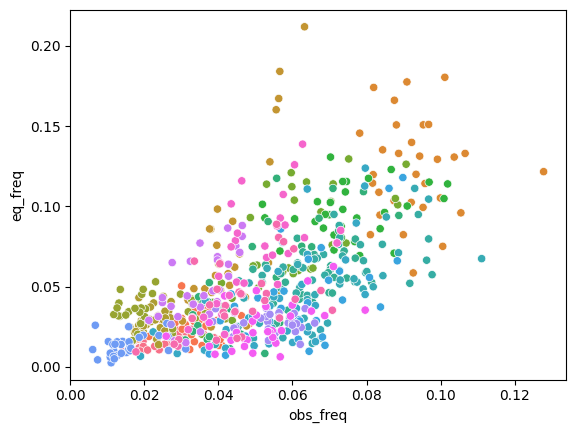

In [5]:
_df_compare = obs_aa_freqs_long.merge(eq_aa_freqs_long, how='inner', on=['taxid', 'amino_acid'])
sns.scatterplot(_df_compare, x='obs_freq', y='eq_freq', hue='amino_acid', legend=False)

In [141]:
eq_aa_freqs.index.intersection(obs_aa_freqs.index).shape, obs_aa_freqs.shape

((31,), (32, 20))

In [142]:
common_taxids = eq_aa_freqs.index\
    .intersection(obs_aa_freqs.index)\
        .intersection(annot.index)
eq_aa_freqs_sample = eq_aa_freqs.loc[common_taxids, aa_order]
obs_aa_freqs_sample = obs_aa_freqs.loc[common_taxids, aa_order]

In [8]:
from itertools import combinations

from scipy.stats import pearsonr, spearmanr

data = []
for t1, t2 in combinations(common_taxids, 2):
    t1_eq_aa_freqs = eq_aa_freqs.loc[t1, aa_order]
    t2_eq_aa_freqs = eq_aa_freqs.loc[t2, aa_order]
    t1_obs_aa_freqs = obs_aa_freqs.loc[t1, aa_order]
    t2_obs_aa_freqs = obs_aa_freqs.loc[t2, aa_order]

    obs_diff = (t1_obs_aa_freqs - t2_obs_aa_freqs)
    eq_diff = (t1_eq_aa_freqs - t2_eq_aa_freqs)

    rho, p = spearmanr(obs_diff, eq_diff)

    # obs_diff['taxid1'] = t1
    # obs_diff['taxid2'] = t2
    # eq_diff['taxid1'] = t1
    # eq_diff['taxid2'] = t2

    data.append([t1, t2, rho, p])

df = pd.DataFrame(data, columns=['taxid1', 'taxid2', 'spearmanr', 'spearman_pval'])
df['virusname1'] = df['taxid1'].map(annot['virusname'])
df['virusname2'] = df['taxid2'].map(annot['virusname'])
df['taxname1'] = df['taxid1'].map(annot['taxname'])
df['taxname2'] = df['taxid2'].map(annot['taxname'])
df['type1'] = df['taxid1'].map(annot['Type'])
df['type2'] = df['taxid2'].map(annot['Type'])
df = df.dropna()
df['pair'] = df.apply(lambda x: str(sorted([x['type1'], x['type2']])), axis=1)
df

,taxid1,taxid2,spearmanr,spearman_pval,virusname1,virusname2,taxname1,taxname2,type1,type2,pair
0,10407,10990,0.437594,0.053661,HBV,RBSDV,Hepatitis B virus,Rice black streaked dwarf virus,ds,ds,"['ds', 'ds']"
1,10407,11082,0.762406,0.000093,HBV,WNV,Hepatitis B virus,West Nile virus,ds,+,"['+', 'ds']"
2,10407,11983,0.485714,0.029921,HBV,norw,Hepatitis B virus,Norwalk virus,ds,+,"['+', 'ds']"
3,10407,12092,0.415038,0.068808,HBV,HAV,Hepatitis B virus,Hepatovirus A,ds,+,"['+', 'ds']"
4,10407,12110,0.135338,0.569419,HBV,FMDV,Hepatitis B virus,Foot-and-mouth disease virus,ds,+,"['+', 'ds']"
...,...,...,...,...,...,...,...,...,...,...,...
460,1933178,3052493,-0.090226,0.705213,aka,PUUV,Akabane orthobunyavirus,Puumala orthohantavirus,-,-,"['-', '-']"
461,1933178,3052763,0.405416,0.076164,aka,RSV,Akabane orthobunyavirus,Rice stripe tenuivirus,-,-,"['-', '-']"
462,3052230,3052493,0.654135,0.001755,HCV,PUUV,Hepacivirus hominis,Puumala orthohantavirus,+,-,"['+', '-']"
463,3052230,3052763,0.697744,0.000625,HCV,RSV,Hepacivirus hominis,Rice stripe tenuivirus,+,-,"['+', '-']"


In [9]:
df.groupby('pair').spearmanr.agg(['mean', 'std', 'min', 'median', 'max'])\
    .sort_values('mean', ascending=False).round(2)

,mean,std,min,median,max
pair,,,,,
"['+', '-']",0.47,0.28,-0.23,0.51,0.93
"['+', '+']",0.46,0.29,-0.34,0.52,0.90
"['+', 'ds']",0.41,0.28,-0.55,0.43,0.83
"['ds', 'ds']",0.40,0.36,-0.29,0.52,0.82
"['-', 'ds']",0.38,0.28,-0.29,0.43,0.86
"['-', '-']",0.20,0.38,-0.57,0.29,0.75


<Axes: xlabel='pair', ylabel='spearmanr'>

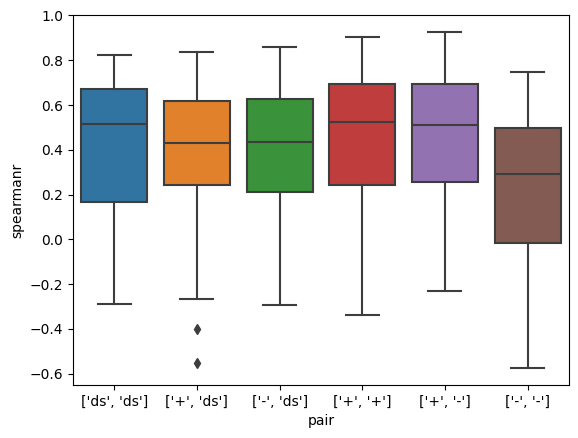

In [10]:
sns.boxplot(
    data=df,
    x='pair',
    y='spearmanr',
)

### compare with spectrum

In [11]:
from scipy.spatial.distance import pdist, squareform

spectrum = pd.read_csv('data/viral_spectra_dataset.csv')\
    .query('df == "nemu"').set_index(['taxid'])
spectrum.index = spectrum.index.astype(int)
cossim = pd.DataFrame(1-squareform(pdist(spectrum.iloc[:, :12], metric='cosine')), 
             index=spectrum.index,
             columns=spectrum.index)

In [12]:
df['cossim'] = df.apply(lambda x: cossim.loc[x['taxid1'], x['taxid2']], axis=1)

In [13]:
df[[ 'spearmanr', 'cossim']].corr(method='spearman').round(2)

,spearmanr,cossim
spearmanr,1.00,-0.42
cossim,-0.42,1.00


<Axes: xlabel='spearmanr', ylabel='cossim'>

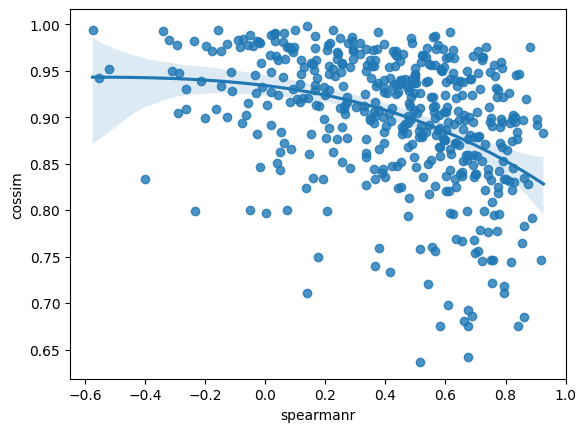

In [19]:
sns.regplot(df, x='spearmanr',  y='cossim', order=3)

In [20]:
df.sort_values('spearmanr', ascending=False).head(15)[
    ['virusname1', 'virusname1', 'taxname1', 'taxname2', 'pair', 'spearmanr', 'cossim']
]

,virusname1,virusname1,taxname1,taxname2,pair,spearmanr,cossim
251,PRRSV,PRRSV,Porcine reproductive and respiratory syndrome ...,Akabane orthobunyavirus,"['+', '-']",0.926316,0.882537
308,HGV,HGV,GB virus C,Akabane orthobunyavirus,"['+', '-']",0.917293,0.746232
298,HGV,HGV,GB virus C,Enterovirus C,"['+', '+']",0.903759,0.897665
394,evD,evD,Enterovirus D,Orthohepevirus A,"['+', '+']",0.903759,0.891410
357,OROV,OROV,Oropouche orthobunyavirus,Hepacivirus hominis,"['+', '-']",0.888722,0.791428
240,PRRSV,PRRSV,Porcine reproductive and respiratory syndrome ...,Enterovirus A,"['+', '+']",0.881203,0.975133
193,denv,denv,Dengue virus,GB virus C,"['+', '+']",0.875188,0.828324
384,evC,evC,Enterovirus C,Hepacivirus hominis,"['+', '+']",0.867669,0.919275
459,aka,aka,Akabane orthobunyavirus,Hepacivirus hominis,"['+', '-']",0.860150,0.783375
300,HGV,HGV,GB virus C,Human metapneumovirus,"['+', '-']",0.860150,0.685151


## LDA

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

common_taxids = eq_aa_freqs.index\
    .intersection(obs_aa_freqs.index)\
        .intersection(annot.index)

eq_aa_freqs_sample = eq_aa_freqs.loc[common_taxids, aa_order]
obs_aa_freqs_sample = obs_aa_freqs.loc[common_taxids, aa_order]

X = obs_aa_freqs_sample
y = annot.loc[common_taxids].Type

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

obs_lda = pd.DataFrame(lda.transform(obs_aa_freqs_sample), 
                       columns=['LDA1', 'LDA2'], 
                       index=obs_aa_freqs_sample.index)
eq_lda = pd.DataFrame(lda.transform(eq_aa_freqs_sample), 
                      columns=['LDA1', 'LDA2'], 
                      index=eq_aa_freqs_sample.index)
obs_lda['Type'] = y.astype('category')
eq_lda['Type'] = y.astype('category')

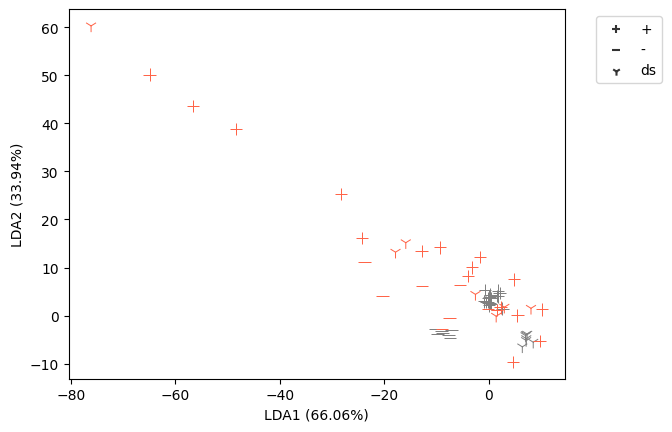

In [26]:
ax = sns.scatterplot(obs_lda, x='LDA1', y='LDA2', style='Type', 
                     markers=['+', '_', '1'], s=80, color='gray')
ax = sns.scatterplot(eq_lda, x='LDA1', y='LDA2', style='Type', 
                     markers=['+', '_', '1'], s=80, color='tomato', ax=ax, legend=False)
# ax.scatter(eq_lda['LDA1'], eq_lda['LDA2'], marker=eq_lda['Type'].cat.codes, c='r', cmap='Set1')
ax.set_xlabel(f"LDA1 ({lda.explained_variance_ratio_[0]:.2%})")
ax.set_ylabel(f"LDA2 ({lda.explained_variance_ratio_[1]:.2%})")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.savefig('figures/lda_obs.png', bbox_inches='tight')
plt.show()

## PCA

<Axes: xlabel='obs_freq', ylabel='eq_freq'>

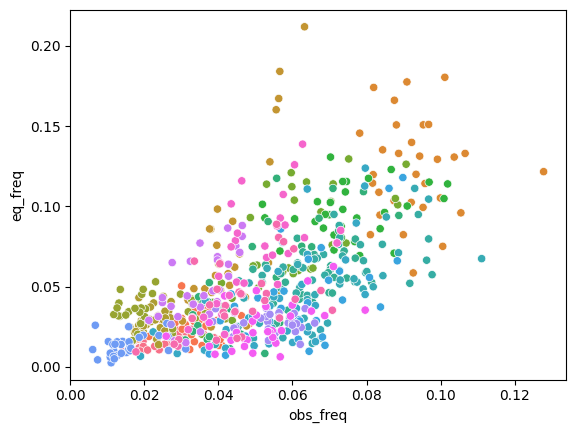

In [135]:
_df_compare = obs_aa_freqs_long.merge(eq_aa_freqs_long, how='inner', on=['taxid', 'amino_acid'])
sns.scatterplot(_df_compare, x='obs_freq', y='eq_freq', hue='amino_acid', legend=False)

In [143]:
eq_aa_freqs.index.intersection(obs_aa_freqs.index).shape, obs_aa_freqs.shape

((31,), (32, 20))

In [ ]:
eq_aa_freqs.index.difference(obs_aa_freqs.index)
# TODO update datasets of aa freqs again...

Index([11320], dtype='int64', name='taxid')

In [110]:
from sklearn.decomposition import PCA

common_taxids = eq_aa_freqs.index\
    .intersection(obs_aa_freqs.index)\
        .intersection(annot.query('Type != "ds"').index)

eq_aa_freqs_sample = eq_aa_freqs.loc[common_taxids, aa_order]
obs_aa_freqs_sample = obs_aa_freqs.loc[common_taxids, aa_order]

X = obs_aa_freqs_sample
y = annot.loc[common_taxids].Type

pca = PCA(2)
pca.fit(X, y)

obs_pca = pd.DataFrame(pca.transform(obs_aa_freqs_sample), 
                       columns=['PC1', 'PC2'], 
                       index=obs_aa_freqs_sample.index).join(annot, how='inner')
eq_pca = pd.DataFrame(pca.transform(eq_aa_freqs_sample), 
                      columns=['PC1', 'PC2'], 
                      index=eq_aa_freqs_sample.index).join(annot, how='inner')
obs_pca['Type'] = y.astype('category')
eq_pca['Type'] = y.astype('category')

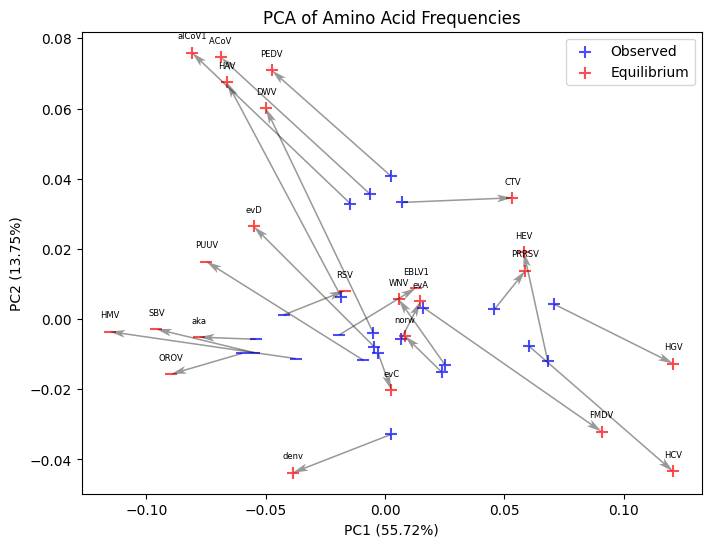

In [153]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the points
ax.scatter(obs_pca.query('Type == "+"')['PC1'], 
           obs_pca.query('Type == "+"')['PC2'], 
           color='blue', label='Observed', 
           alpha=0.7, marker='+', s=70)
ax.scatter(obs_pca.query('Type == "-"')['PC1'], 
           obs_pca.query('Type == "-"')['PC2'], 
           color='blue', 
           alpha=0.7, marker='_', s=70)
ax.scatter(eq_pca.query('Type == "+"')['PC1'], 
           eq_pca.query('Type == "+"')['PC2'], 
           color='red', label='Equilibrium', 
           alpha=0.7, marker='+', s=70)
ax.scatter(eq_pca.query('Type == "-"')['PC1'], 
           eq_pca.query('Type == "-"')['PC2'], 
           color='red', 
           alpha=0.7, marker='_', s=70)

# Plot arrows
for taxid in obs_pca.index.intersection(eq_pca.index):
    ax.quiver(
        obs_pca.loc[taxid, 'PC1'], obs_pca.loc[taxid, 'PC2'], 
        eq_pca.loc[taxid, 'PC1'] - obs_pca.loc[taxid, 'PC1'], 
        eq_pca.loc[taxid, 'PC2'] - obs_pca.loc[taxid, 'PC2'], 
        angles='xy', scale_units='xy', scale=1, color='k', 
        alpha=0.4, width=0.0025, headwidth=5, headlength=10, headaxislength=8,
    )
    # Add labels for some points
    ax.annotate(
        obs_pca.loc[taxid, 'virusname'],
        (eq_pca.loc[taxid, 'PC1'], eq_pca.loc[taxid, 'PC2']), 
        textcoords="offset points", 
        xytext=(0, 10), 
        ha='center', fontsize=6,
    )

# Add labels and legend
ax.legend()
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%})")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%})")
plt.title('PCA of Amino Acid Frequencies')
# plt.grid()
plt.show()

/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/seaborn/_oldcore.

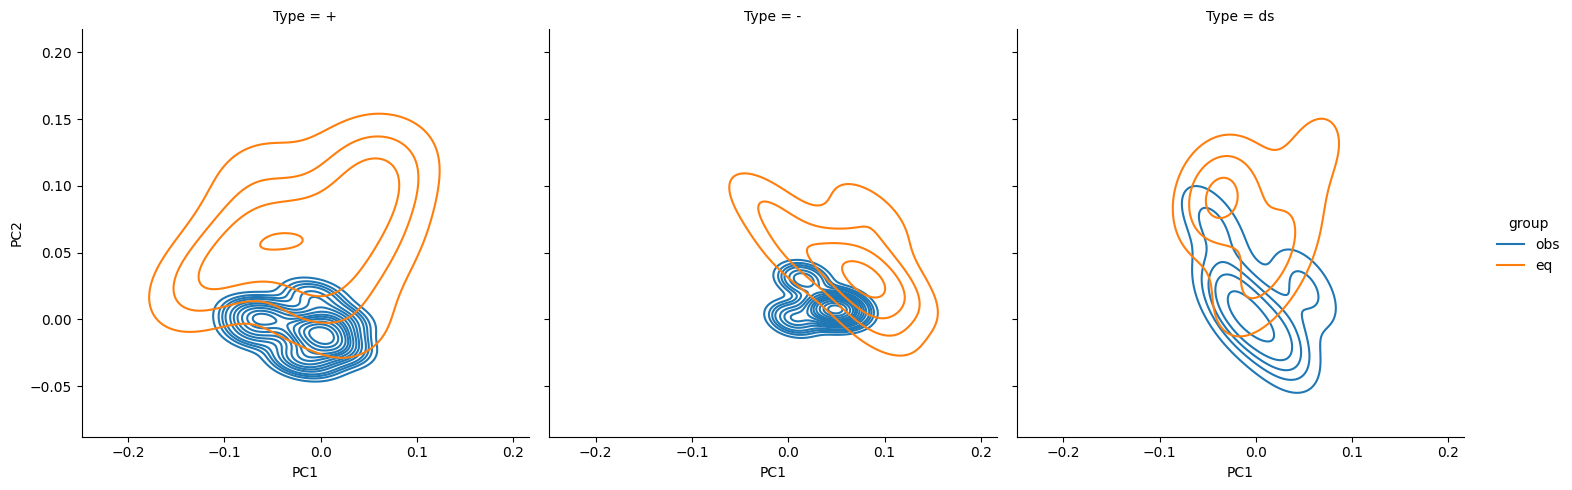

In [29]:
g = sns.displot(
    pd.concat([obs_pca.assign(group='obs'), eq_pca.assign(group='eq')]),
    x='PC1', y='PC2',
    hue='group',
    col='Type',
    kind='kde',
    levels=15, 
)